In [1]:
#Configuração do Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Acrescenta as variáveis do java
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)


In [2]:
!pip install pyspark==2.4.6

     |████████████████████████████████| 218.4MB 62kB/s 
     |████████████████████████████████| 204kB 44.0MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.6-py2.py3-none-any.whl size=218814406 sha256=cc26ae3c1ba02593e0be13d7cadd444df1e7aea458654a16b8bc73f1584cf721
  Stored in directory: /root/.cache/pip/wheels/1e/5e/6a/17e906c94ec7246f260330a66e44a06a0809033ba2738a74a8
Successfully built pyspark


In [3]:
# Importando a sessão do spark, suas funções e tipos

from pyspark.sql import SparkSession
import pyspark.sql.functions as psFunctions
from pyspark.sql.types import *

In [4]:
# Upload do csv utilizado para a máquina
from google.colab import files
uploaded = files.upload()

Saving join-dados-goiania-corrigidos.csv to join-dados-goiania-corrigidos.csv


In [5]:
# Montagem do Spark, comando config auxilia na visualização das tabelas moldando um layout ao invés de tracinhos
spark = SparkSession.builder \
                    .appName("CasosLinhas") \
                    .config('spark.sql.repl.eagerEval.enabled', 'true') \
                    .getOrCreate()

In [6]:
# Importando csv com separador em ;, inferindo cabeçalho
dfInicial = spark.read.csv('join-dados-goiania-corrigidos.csv', sep=";", inferSchema=True, header=True)

In [7]:
# Printando esquema das colunas
dfInicial.printSchema()

root
 |-- uid: string (nullable = true)
 |-- dataNotificacao: timestamp (nullable = true)
 |-- dataInicioSintomas: string (nullable = true)
 |-- dataNascimento: timestamp (nullable = true)
 |-- sintomas: string (nullable = true)
 |-- profissionalSaude: string (nullable = true)
 |-- cbo: string (nullable = true)
 |-- condicoes: string (nullable = true)
 |-- estadoTeste: string (nullable = true)
 |-- dataTeste: string (nullable = true)
 |-- tipoTeste: string (nullable = true)
 |-- resultadoTeste: string (nullable = true)
 |-- paisOrigem: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- bairro: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- estadoIBGE: integer (nullable = true)
 |-- municipio: string (nullable = true)
 |-- municipioIBGE: integer (nullable = true)
 |-- cep: string (nullable = true)
 |-- origem_caso: string (nullable = true)
 |-- cnes: string (nullable = true)
 |-- estadoNotificacao: string (nullable = true)
 |-- estadoNotificacaoIBGE: 

**Filtragem de valores erroneos nulos ou valores estranhos para os resultados**

In [ ]:
dfFiltroBase = dfInicial.filter("bairro_certo is not null and \
                                 bairro_certo not in ('', 'null', 'undefined', '0', '00', '000', '0000') and \
                                 origem_bairro_tratado is not null and \
                                 origem_bairro_tratado not in (0, '0', '000', '.', '74715-430') and \
                                 destino_bairro_tratado is not null and \
                                 destino_bairro_tratado not in (0, '0', '000', '.', '74715-430') and \
                                 linha is not null and \
                                 municipio = 'Goiânia' and \
                                 evolucaoCaso != 'Cancelado'")

## **Projeto - Análise dos Casos no Estado**

## **Projeto - Análise dos Casos em Goiânia**

**Visualizando evolução caso**

In [ ]:
dfFiltroBase.groupBy(["evolucaoCaso"]).agg(psFunctions.countDistinct("uid").alias("qtde")).orderBy("qtde", ascending=False)

evolucaoCaso,qtde
Ignorado,3753
Cura,710
Em tratamento dom...,164
Internado,2
Internado em UTI,2


**Visualizando a quantidade de casos por sexo**

In [ ]:
dfFiltroBase.groupBy(["sexo"]).agg(psFunctions.countDistinct("uid").alias("qtde")).orderBy("qtde", ascending=False)

sexo,qtde
Feminino,2424
Masculino,2207


**Testando agrupamentos (Ranking por bairro em cada mês)**

In [ ]:
dfFiltroBase.groupby("bairro_certo", psFunctions.month("dataNotificacao").alias("mes")) \
            .agg(psFunctions.countDistinct("uid").alias("qtde")) \
            .filter("bairro_certo == 'bueno'") \
            .orderBy(["mes","qtde"], ascending=False)

bairro_certo,mes,qtde
bueno,7,57
bueno,6,237
bueno,5,90
bueno,4,42
bueno,3,2


**Quantidade de casos Confirmados VS Clínico Epidemiológico**

In [ ]:
dfFiltroBase.groupBy("classificacaoFinal") \
            .agg(psFunctions.countDistinct("uid").alias("qtde")) \
            .orderBy("qtde", ascending=False) \
            .show(truncate=False)

+---------------------------------+----+
|classificacaoFinal               |qtde|
+---------------------------------+----+
|Confirmado Laboratorial          |4625|
|Confirmado Clínico-Epidemiológico|6   |
+---------------------------------+----+



**Quantidade de casos por Condições do Paciente**

In [ ]:
dfFiltroBase.groupBy("condicoes") \
            .agg(psFunctions.countDistinct("uid").alias("qtde")) \
            .orderBy("qtde", ascending=False) \
            .show(truncate=False)

+---------------------------------------------------------------------------------------------------+----+
|condicoes                                                                                          |qtde|
+---------------------------------------------------------------------------------------------------+----+
|Ok                                                                                                 |4230|
|Doenças cardíacas crônicas                                                                         |162 |
|Doenças respiratórias crônicas descompensadas                                                      |72  |
|Diabetes                                                                                           |61  |
|Diabetes, Doenças cardíacas crônicas                                                               |25  |
|Imunossupressão                                                                                    |15  |
|Doenças renais crônicas em estágio a

In [ ]:
# Substitui as condições null por OK, já que o paciente está "saudavel"
# Executar novamente o agrupamento acima

dfFiltroBase = dfFiltroBase.withColumn("condicoes", psFunctions.when(dfFiltroBase.condicoes == "null", "Ok") \
                                                               .when(dfFiltroBase.condicoes.isNull() == True, "Ok") \
                                                               .otherwise(dfFiltroBase.condicoes))

**Alteração da Coluna Validado e Excluido de undefined p/ Boleano**

In [ ]:
dfFiltroBase = dfFiltroBase.withColumn('excluido', psFunctions.when(dfFiltroBase.excluido == 'undefined', False).otherwise(True)) \
                           .withColumn('validado', psFunctions.when(dfFiltroBase.validado == 'undefined', False).otherwise(True))

In [ ]:
dfFiltroBase.select(["excluido", "validado"]).limit(5)

excluido,validado
false,false
false,false
false,false
false,false
false,false


**Seleção de colunas do dataset para análise**

In [ ]:
dfFiltroV2 = dfFiltroBase.select(["uid", "dataNotificacao", "dataInicioSintomas", \
                                  "sintomas", "dataTeste", "tipoTeste", \
                                  "resultadoTeste", "sexo", "bairro_certo", \
                                  "cep", "origem_caso", "excluido", \
                                  "validado", "idade", "dataEncerramento", \
                                  "evolucaoCaso", "classificacaoFinal", "linha", \
                                  "origem_bairro_tratado", "destino_bairro_tratado", "cidade_uf_origem", \
                                  "cidade_uf_destino", "tipo_join"])

**Setor Leste Universitário tem a maior quantidade de CEPS nulos, depois de Jardim Novo Mundo e Parque Atheneu**

In [ ]:
dfFiltroV2.select(["bairro_certo", "cep"]).filter("cep is null") \
          .groupBy("bairro_certo").count().orderBy("count", ascending=False)

bairro_certo,count
leste universitario,74
jardim novo mundo,25
parque atheneu,12
pedro ludovico,12
coimbra,9
goiania viva,9
jardim goias,8
bueno,4
jardim curitiba,4
marista,3


**Etapa de Limpeza da Coluna Sintomas**

In [ ]:
# Da o split com virgula e espaço
dfFiltroV3 = dfFiltroV2.withColumn("sintomas", psFunctions.split(dfFiltroV2.sintomas, ', '))
dfFiltroV3 = dfFiltroV3.withColumn("sintomas", psFunctions.explode(dfFiltroV3.sintomas))

In [ ]:
# Da o split com virgula somente
dfFiltroV3 = dfFiltroV3.withColumn("sintomas", psFunctions.split(dfFiltroV3.sintomas, ','))
dfFiltroV3 = dfFiltroV3.withColumn("sintomas", psFunctions.explode(dfFiltroV3.sintomas))

**Quantidade de casos separados por sintomas notificados na ficha**

In [ ]:
dfFiltroV3.groupBy("sintomas").agg(psFunctions.countDistinct("uid").alias("qtde")).orderBy("qtde", ascending=False).show(15, truncate=False)

+------------------------------+----+
|sintomas                      |qtde|
+------------------------------+----+
|Outros                        |2930|
|Tosse                         |2143|
|Febre                         |2045|
|Dor de Garganta               |1117|
|Dispneia                      |974 |
|Outros: Paciente assintomático|7   |
+------------------------------+----+



**Calculando a Diferença em dias das Datas de Notificação e Encerramento**

In [ ]:
dfFiltroV4 = dfFiltroV3.withColumn("demoraNotificacaoDias", psFunctions.datediff(dfFiltroV3.dataEncerramento, dfFiltroV3.dataNotificacao))

In [ ]:
dfFiltroV4.groupBy("uid", "bairro_certo", "sexo", "idade", "demoraNotificacaoDias") \
          .agg(psFunctions.countDistinct("uid").alias("qtde")) \
          .filter("demoraNotificacaoDias > 0") \
          .orderBy(["demoraNotificacaoDias"], ascending=False) \
          .limit(5)

uid,bairro_certo,sexo,idade,demoraNotificacaoDias,qtde
bIjYI81BJ5,pedro ludovico,Feminino,39,83,1
qqQaliPS1T,eldorado,Feminino,30,79,1
XL7E23IPBi,jardim curitiba,Feminino,63,76,1
sPLk5F6lNr,vila santa helena,Masculino,33,75,1
rgril65Lb5,jardim europa,Feminino,9,75,1


**Calculando a Diferença em dias das Datas de Inicio dos Sintomas e Notificacao**

In [ ]:
dfFiltroV4 = dfFiltroV4.withColumn("demoraIdaMedicoDias", psFunctions.datediff(dfFiltroV4.dataNotificacao, dfFiltroV4.dataInicioSintomas))

In [ ]:
dfFiltroV4.groupBy("uid", "bairro_certo", "sexo", "idade", "demoraIdaMedicoDias") \
          .agg(psFunctions.countDistinct("uid").alias("qtde")) \
          .filter("demoraIdaMedicoDias > 0") \
          .orderBy(["demoraIdaMedicoDias"], ascending=False) \
          .limit(5)

uid,bairro_certo,sexo,idade,demoraIdaMedicoDias,qtde
s0vWrfKnzE,buena vista,Feminino,40,126,1
lp3sqxDH6H,leste universitario,Feminino,33,122,1
GuMWKKBKEw,jardim goias,Masculino,37,108,1
RpbTLYQ3DN,vila vera cruz,Masculino,52,94,1
eKDzWNKfH4,estrela dalva,Feminino,51,90,1


**Indexação da Coluna Idade usando when +**

In [ ]:
dfModelo = dfFiltroV4.withColumn("idade", psFunctions.when((dfFiltroV4.idade >= '0') & (dfFiltroV4.idade < '5'), "0) 0 até 4")
                                                     .when((dfFiltroV4.idade >= '10') & (dfFiltroV4.idade < '20'), "1) 10 até 19")
                                                     .when((dfFiltroV4.idade >= '20') & (dfFiltroV4.idade < '30'), "2) 20 até 29")
                                                     .when((dfFiltroV4.idade >= '30') & (dfFiltroV4.idade < '40'), "3) 30 até 39")
                                                     .when((dfFiltroV4.idade >= '40') & (dfFiltroV4.idade < '50'), "4) 40 até 49")
                                                     .when((dfFiltroV4.idade >= '50') & (dfFiltroV4.idade < '60'), "5) 50 até 59")
                                                     .when((dfFiltroV4.idade >= '60'), "6) Acima de 60"))

# Mudança de nome da coluna
dfModelo = dfModelo.withColumnRenamed("idade", "faixaEtaria")

**Visualização de Dados**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


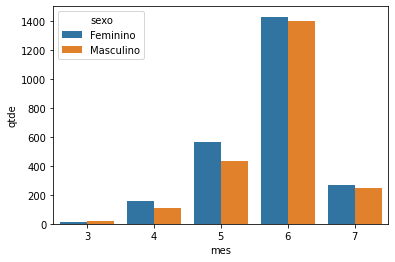

In [ ]:
# Graficos em barra para a quantidade de casos por sexo ao mes

dfBar = dfModelo.groupby("sexo", psFunctions.month("dataNotificacao").alias("mes")) \
                .agg(psFunctions.countDistinct("uid").alias("qtde")) \
                .orderBy(["qtde"], ascending=False)
                #.filter("bairro_certo == 'bueno'") \

sns.barplot(x="mes", y="qtde", hue="sexo", data=dfBar.toPandas());

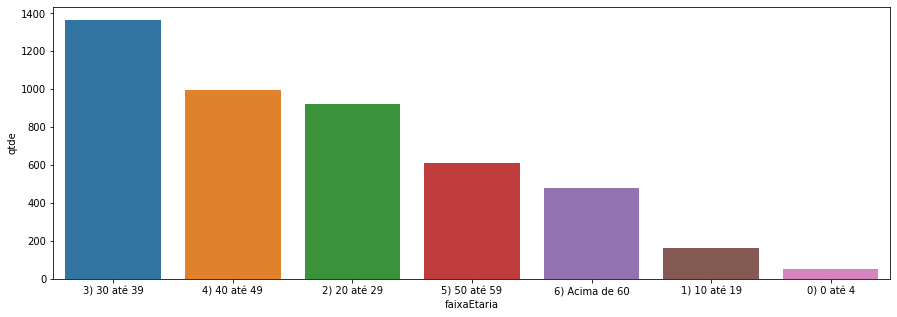

In [ ]:
# Graficos em barra para a quantidade de casos

dffaixa = dfModelo.groupby("faixaEtaria").agg(psFunctions.countDistinct("uid").alias("qtde")) \
                  .orderBy(["qtde"], ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(x="faixaEtaria", y="qtde", data=dffaixa.toPandas());

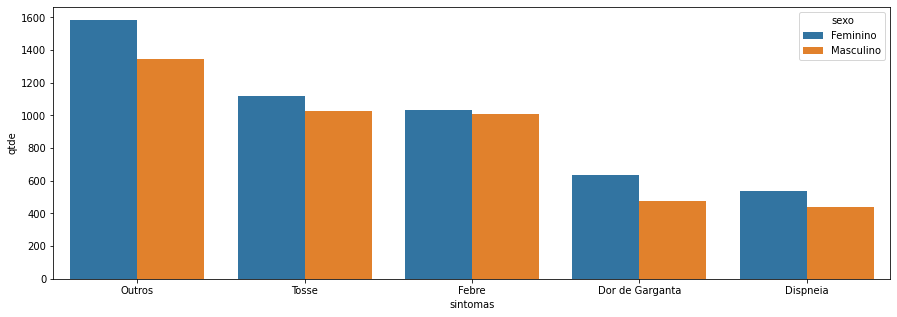

In [ ]:
# Gráfico em barra da quantidade de casos por sintoma e sexo
# 7 casos para o sintoma Outros: Paciente assintomático = descartado

dfSintomas = dfModelo.groupby("sintomas", "sexo") \
                     .agg(psFunctions.countDistinct("uid").alias("qtde")) \
                     .filter("sintomas != 'Outros: Paciente assintomático'") \
                     .orderBy(["qtde"], ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(x="sintomas", y="qtde", hue="sexo", data=dfSintomas.toPandas());

In [ ]:
# Retirando as horas conforme combinado com o grupo

dfModelo = dfModelo.withColumn("dataNotificacao", dfModelo.dataNotificacao.cast('date'))
dfModelo = dfModelo.withColumn("dataInicioSintomas", dfModelo.dataInicioSintomas.cast('date'))
dfModelo = dfModelo.withColumn("dataEncerramento", dfModelo.dataEncerramento.cast('date'))

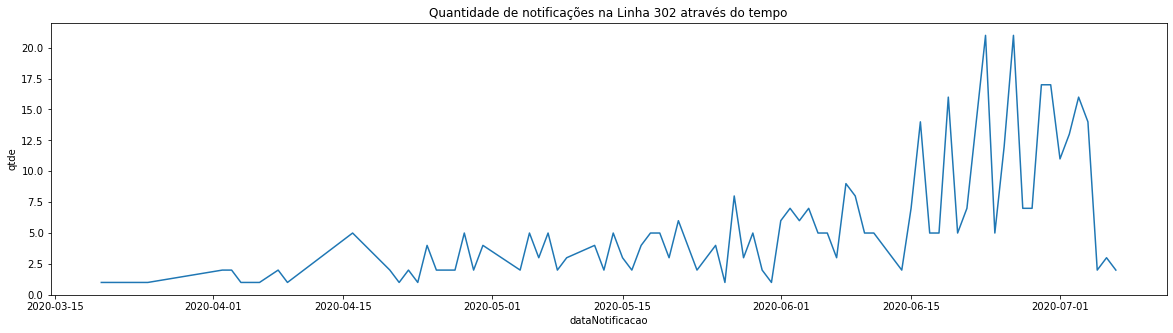

In [ ]:
# Relação da quantidade de casos através do tempo

dfTempo = dfModelo.filter("linha == '302'") \
                  .groupby("dataNotificacao") \
                  .agg(psFunctions.countDistinct("uid").alias("qtde")) \
                  .orderBy(["qtde"], ascending=False)

plt.figure(figsize=(20,5))
plt.title("Quantidade de notificações na Linha 302 através do tempo")
sns.lineplot(x="dataNotificacao", y="qtde",data=dfTempo.toPandas())

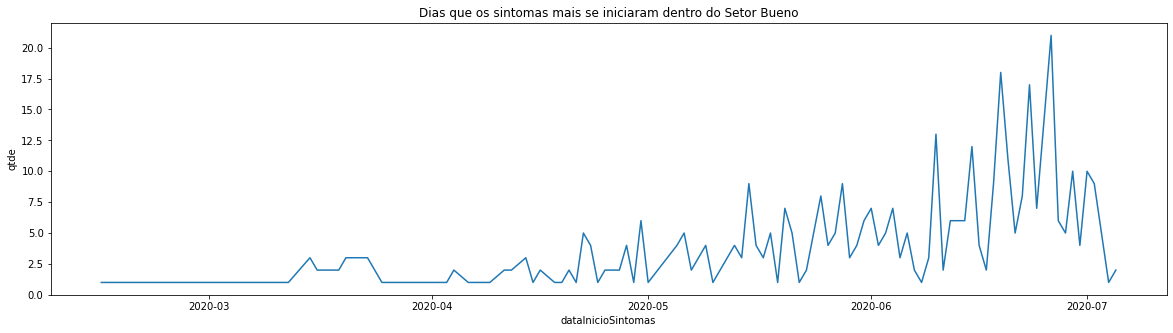

In [ ]:
# Inicio dos Sintomas em quantidade dentro do Setor Bueno

dfIniTempo = dfModelo.filter("bairro_certo == 'bueno'") \
                  .groupby("dataInicioSintomas") \
                  .agg(psFunctions.countDistinct("uid").alias("qtde")) \
                  .orderBy(["qtde"], ascending=False)

plt.figure(figsize=(20,5))
plt.title("Dias que os sintomas mais se iniciaram dentro do Setor Bueno")
sns.lineplot(x="dataInicioSintomas", y="qtde",data=dfIniTempo.toPandas())

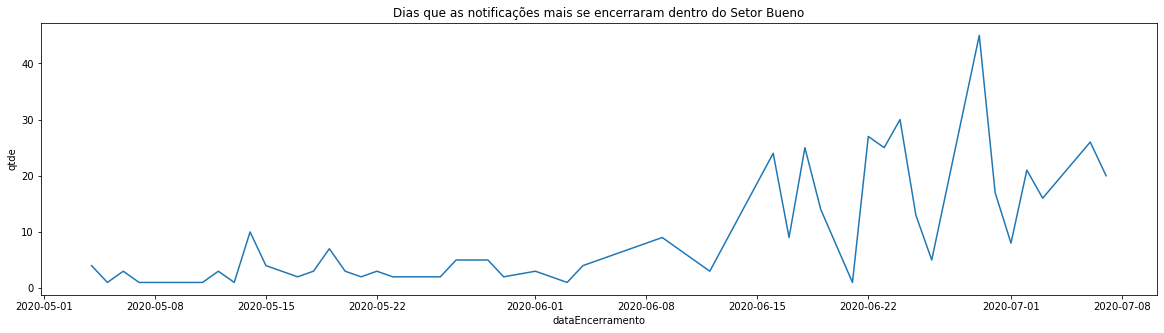

In [ ]:
# Poucos notificações foram encerradas de maio para trás, logo filtraremos esse intervalo

dfEndTempo = dfModelo.filter("bairro_certo == 'bueno' and dataEncerramento >= '2020-05'") \
                     .groupby("dataEncerramento") \
                     .agg(psFunctions.countDistinct("uid").alias("qtde")) \
                     .orderBy(["qtde"], ascending=False)

plt.figure(figsize=(20,5))
plt.title("Dias que as notificações mais se encerraram dentro do Setor Bueno")
sns.lineplot(x="dataEncerramento", y="qtde",data=dfEndTempo.toPandas())

**Regressão Linear Utilizando Prophet do Facebook**


In [ ]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [ ]:
dfTempo.limit(5)

dataNotificacao,qtde
2020-06-23,21
2020-06-26,21
2020-06-29,17
2020-06-30,17
2020-07-03,16


In [ ]:
# Chamando dataframe dos casos pelo tempo na linha 302

dfTempo = dfTempo.withColumnRenamed("dataNotificacao", "ds")
dfTempo = dfTempo.withColumnRenamed("qtde", "y")

In [ ]:
# Cria o modelo, traz sasonalidade diárias e semanais 
# e treina com a versão do dataframe em pandas

model = Prophet(interval_width=0.95,
                growth="linear",
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=False)

model.fit(dfTempo.toPandas())

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
# Cria um dataframe de previsões para os próximos 3 meses

predicaoFutura = model.make_future_dataframe(periods=30*3, freq="d", include_history=True)
forecast_predicao = model.predict(predicaoFutura)

In [ ]:
# Traz o dataframe com os valores da predição, juntamente com o intervalo de incerteza

forecast_predicao[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
169,2020-10-01,19.708644,13.306197,26.284972
170,2020-10-02,21.093957,14.468658,27.096679
171,2020-10-03,17.890906,11.237384,24.517655
172,2020-10-04,16.537522,9.764803,23.251237
173,2020-10-05,19.992756,13.593415,26.617431


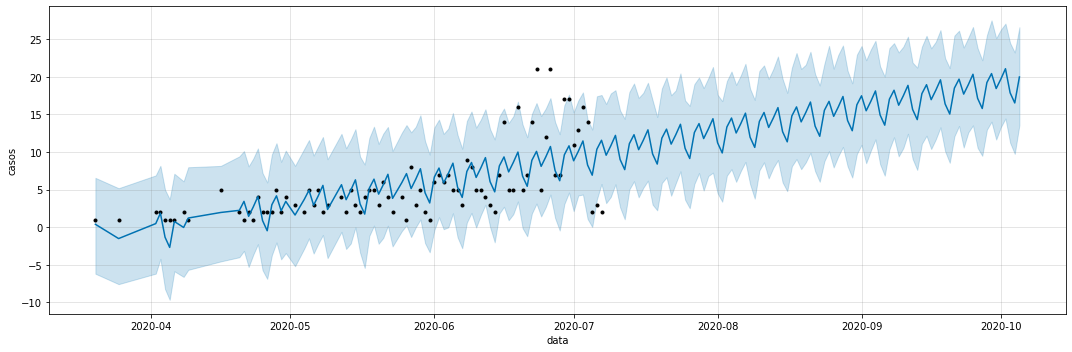

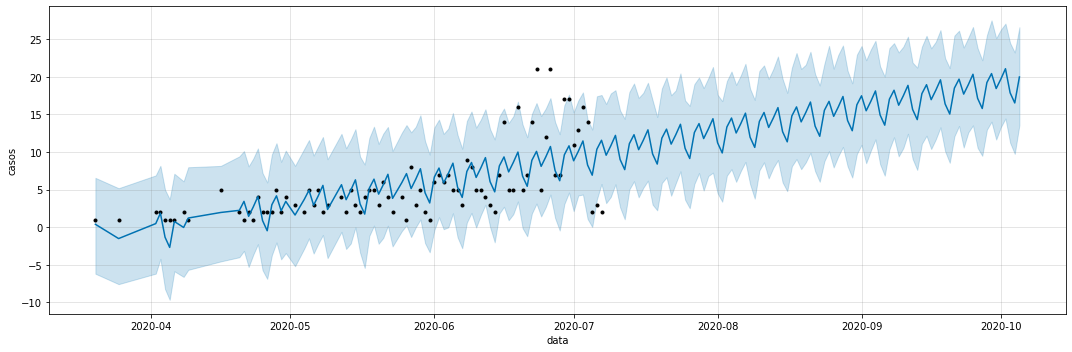

In [ ]:
# Plotagem do gráfico
# Faixa em azul claro é o intervalo de incerteza
# Linha em azul escuro representa os valores da predição

model.plot(forecast_predicao, xlabel='data', ylabel='casos', figsize=(15, 5))

**Cross-Validation e Utilização de RMSE para avaliação da predição**

In [ ]:
dfCross = cross_validation(model, initial="60 days", period="10 days", horizon="28 days")
dfCross.head()

INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-20 00:00:00 and 2020-06-09 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-05-21,4.708288,2.967888,6.504498,6,2020-05-20
1,2020-05-22,4.038157,2.185268,5.978920,4,2020-05-20
2,2020-05-23,3.412456,1.501769,5.266563,2,2020-05-20
3,2020-05-25,3.825316,2.051619,5.803868,4,2020-05-20
4,2020-05-26,5.065286,3.222686,6.864111,1,2020-05-20


In [ ]:
# Diversas métricas para a predição dos casos

dfPerformance = performance_metrics(dfCross)
dfPerformance.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,2.842806,1.686062,1.481887,0.535578,0.318219,0.916667
1,4 days,2.481467,1.575267,1.453104,0.350548,0.318219,1.000000
2,5 days,2.883074,1.697962,1.579641,0.458709,0.372819,1.000000
3,6 days,3.792097,1.947331,1.553653,0.806856,0.244587,0.875000
4,7 days,12.462378,3.530209,2.646189,0.818838,0.406217,0.625000


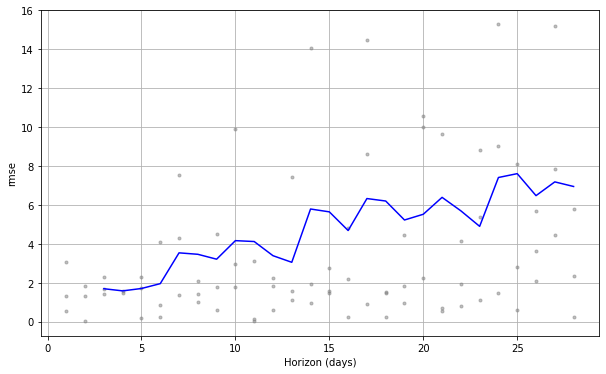

In [ ]:
# A linha em azul traça uma predição que
# tenta reduzir ao máximo a taxa de erro mínimo quadrado..

# O rmse é a distancia entre os valores observados (quantidade de casos)
# vs os valores da predição (quantidade de casos no futuro)

# Quanto menor o valor do erro, melhor é a predição

fig = plot_cross_validation_metric(dfCross, metric="rmse")

In [ ]:
spark.stop()